In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'Vls', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10153


,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.11,73150,200275.0,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.72,120,202766.0,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.61,12,210177.0,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.30,16,211419.0,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.71,0.43,33.70,0.26,33.71,0.25,33.89,55,NaN,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [4]:
df['Vmod'] = df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [6]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
10,2.47
12,3.40


In [7]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"Vls":"V3k"})

df.head()

,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,logD75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.349020,73150,200275.0,...,1.869804,NaN,NaN,NaN,NaN,-22.459020,NaN,NaN,NaN,4.73
4,1,33.49,0.38,33.44,0.19,33.54,0.19,34.011709,120,202766.0,...,1.802342,-18.421709,-18.681709,-18.891709,-18.941709,-17.941709,0.47,1.96,0.07,1.85
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.779466,12,210177.0,...,1.955893,NaN,NaN,NaN,NaN,-21.189466,NaN,NaN,NaN,3.40
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.491034,16,211419.0,...,1.898207,-20.131034,-20.631034,-20.911034,-21.091034,-20.501034,0.78,NaN,NaN,1.19
55,1,33.71,0.43,33.70,0.26,33.71,0.25,34.167913,55,NaN,...,1.833583,-18.637913,-18.847913,-18.947913,-18.997913,-17.967913,0.31,NaN,NaN,4.30


In [8]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

# df["F21"] = dg.F21_
# df["eF21"] = dg.F21_e

<ipython-input-8-69eae98da3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-8-69eae98da3b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


10153

In [9]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10153

In [10]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536]
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi', 'g***', 'r***', 'i***', 'z***']]).dropna()
calib = calib[(calib.Qs>2) & (calib['i']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)


for waveband in ['g***','r***','i***','z***']:
    calib[waveband] = calib.apply(lambda x: x[waveband] if x[waveband]!=0 else np.nan, axis=1)
for waveband in ['g','r','i','z']:
    calib[waveband+'***'] = calib.apply(lambda x: x[waveband+'***'] if x[waveband]!=0 else np.nan, axis=1)

calib['Mr'] = calib['r***']-calib.dm19
calib['Mi'] = calib['i***']-calib.dm19
calib['Mz'] = calib['z***']-calib.dm19
calib['gi'] = calib["g***"]-calib['i***']


calib['logMs_i']  = 1.619 + 0.510*calib.gi - 0.4*calib['Mi']
calib['logMs_r']  = 1.617 + 0.650*calib.gi - 0.4*calib['Mr']
calib['logMs_z']  = 1.610 + 0.461*calib.gi - 0.4*calib['Mz']


alfa = 0.536
beta = 1.616
calib['logMs_riz'] = beta + alfa*calib.gi - 0.4*calib.Mi

calib['Ms_riz'] = 10**calib.logMs_riz
calib = calib.dropna()

print(len(calib))
calib.head()

45


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,i***,z***,Dist,Mass_HI,gi,logMs_i,logMs_r,logMs_z,logMs_riz,Ms_riz
PGC,,,,,,,,,,,,,,,,,,,,,
21396,2,NGC2403,27.514,58,2.454,0.026,-18.56,-19.43,-19.704,-19.854,...,7.66,7.64,3.182731,3.273213e+09,0.42,9.7748,9.7716,9.75322,9.78272,6.063453e+09
28357,2,NGC3021,32.327,58,2.454,0.022,-19.11,-20.11,-20.617,-20.897,...,11.43,11.30,29.201153,2.535331e+09,0.79,10.3807,10.3773,10.38499,10.39824,2.501727e+10
32192,2,NGC3368,30.165,52,2.630,0.024,-19.29,-20.67,-21.355,-21.715,...,8.45,8.31,10.789467,2.248998e+09,1.04,10.8354,10.8350,10.83144,10.85944,7.235024e+10
32207,2,NGC3370,32.149,56,2.514,0.021,-19.43,-20.22,-20.589,-20.779,...,11.37,11.30,26.902956,4.424994e+09,0.56,10.2162,10.2166,10.20776,10.22776,1.689507e+10
34695,2,NGC3627,30.125,64,2.605,0.015,-20.04,-21.16,-21.715,-21.985,...,8.14,7.99,10.592537,1.206747e+09,0.82,10.8312,10.8360,10.84202,10.84952,7.071638e+10


In [11]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

mc = -6.16e-05
def HI_corrector(mc, bc, V3k):
    return mc*V3k+bc

In [180]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']


df['logMs_riz'] = df['logMs_i']
df['Ms_riz'] = 10**df.logMs_riz
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

N = len(df)
df['logMs_riz_color'] = df['logMs_i'] + np.random.normal(0, 0.1, size=N)
df['Ms_riz_color'] = 10**df.logMs_riz_color
df['Mb_color'] = df.Ms_riz_disp + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb_color'] = np.log10(df.Mb_color.values)


N = len(df)
df['logMs_riz_gas'] = df['logMs_i']
df['Ms_riz_gas'] = 10**df.logMs_riz_gas
df['Mb_gas'] = df.Ms_riz_gas + (1.33+np.random.normal(0, 0.1, size=N))*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb_gas'] = np.log10(df.Mb_gas.values)


N = len(df)
df['logMs_riz_all'] = df['logMs_i'] + np.random.normal(0, 0.10, size=N)
df['Ms_riz_all'] = 10**df.logMs_riz_all
df['Mb_all'] = df.Ms_riz_all + (1.33+np.random.normal(0, 0.1, size=N))*(10**(np.log10(df.Mass_HI*(1+np.random.normal(0, 0.04, size=N)))+HI_corrector(np.random.normal(mc, 0.2E-5, size=N), 0, df.V3k.values)+0.40*np.random.normal(0, 1, size=N)))
df['logMb_all'] = np.log10(df.Mb_all.values)

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [181]:
df.columns

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'V3k', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg', 'Vmod', 'D75', 'logD75', 'Mg_75', 'Mr_75',
       'Mi_75', 'Mz_75', 'M1_75', 'gi', 'F', 'e_F', 'Flux', 'F21_av', 'Ms_W1',
       'Mass_HI', 'logMs_i', 'logMs_r', 'logMs_z', 'Ms_riz', 'Mb',
       'logMs_riz_disp', 'Ms_riz_disp', 'Mb_disp', 'logMb_disp',
       'logMs_riz_color', 'Ms_riz_color', 'Mb_color', 'logMb_color',
       'logMs_riz_gas', 'Ms_riz_gas', 'Mb_gas', 'logMb_gas', 'logMs_riz_all',
       'Ms_riz_all', 'Mb_all', 'logMb_all'],
      dtype='object')

In [182]:
dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]

m0 = 3.433
b0 = 10.366
    
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

4.761904761904762

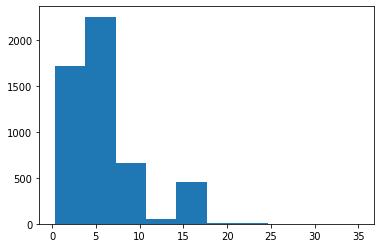

In [183]:
x = 100*dff.eF21/dff.F21

plt.hist(x)

np.median(x)

0.08315033652970548


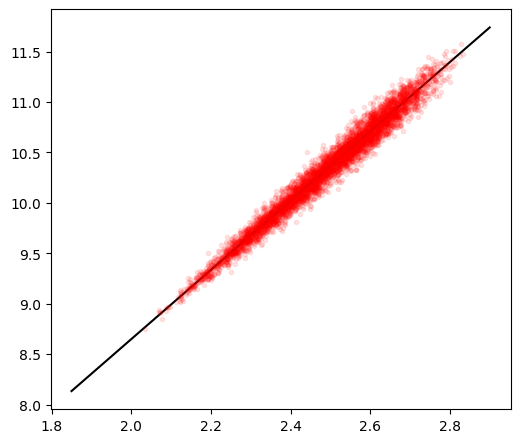

In [184]:
logW_simul = (logMass-b0) / m0 + 2.5

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
## ax.plot(logW_simul, logMass, 'k.')
ax.plot(logW_simul, dff.logMb_color.values, 'r.', alpha=0.1)

delta = logMass - dff.logMb_color.values
print(np.std(delta))

0.008188084573320358


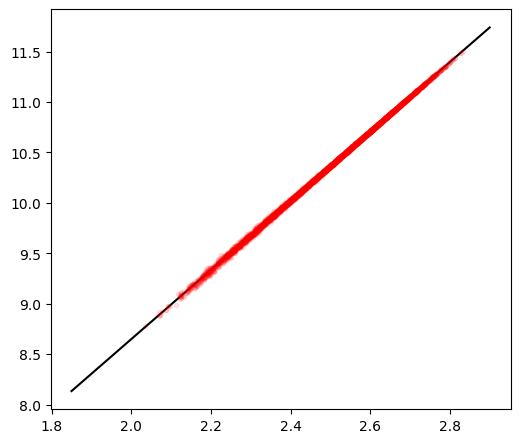

In [185]:
logW_simul = (logMass-b0) / m0 + 2.5

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
## ax.plot(logW_simul, logMass, 'k.')
ax.plot(logW_simul, dff.logMb_gas.values, 'r.', alpha=0.1)

delta = logMass - dff.logMb_gas.values
print(np.std(delta))

0.0686297408532106


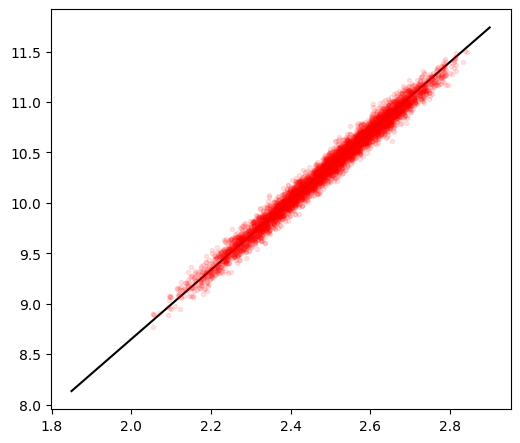

In [186]:
logW_simul = (logMass-b0) / m0 + 2.5

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
logW_disp = logW_simul + np.random.normal(0, 0.02, size=len(dff))
ax.plot(logW_disp, logMass, 'r.', alpha=0.1)

delta = logMass - (m0*(logW_disp-2.5) + b0)
print(np.std(delta))

0.023439052795031057

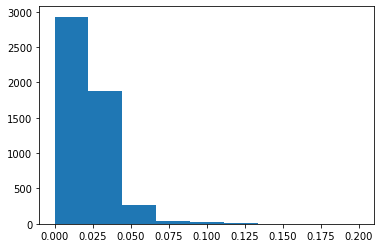

In [187]:
plt.hist(logWe, bins=np.linspace(0,0.2,10))

np.mean(logWe)

0.1616797472353511


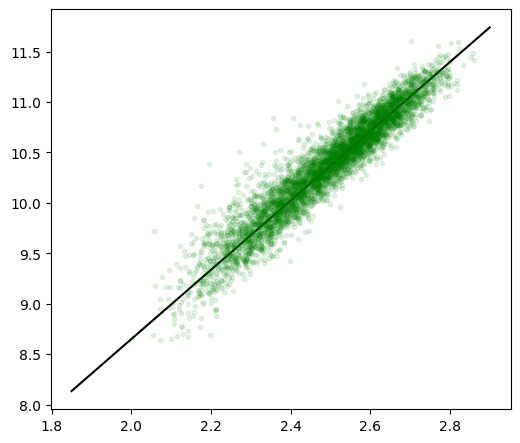

In [188]:
logW_simul = (logMass-b0) / m0 + 2.5

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
logW_disp = logW_simul + np.random.normal(0, 0.025, size=len(dff))
ax.plot(logW_disp, dff.logMb_all.values, 'g.', alpha=0.1)

delta = dff.logMb_all.values - (m0*(logW_disp-2.5) + b0)
print(np.std(delta))

0.20046369051457344


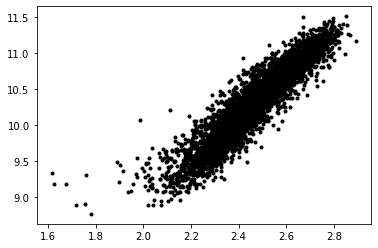

In [99]:
plt.plot(logW, logMass, 'k.')

delta = logMass - (m0*(logW-2.5) + b0)
print(np.std(delta))